In [67]:
import pandas as pd
import glob

files = sorted(glob.glob('run_ca*.csv'))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print(f"Loaded {len(files)} files, total rows = {len(df)}")
df.head()


Loaded 3 files, total rows = 6018


,run_id,episode_index,step_count,time_start,time_end,time_delta_ms,observation_state,action_taken,reward_received,terminated,bits_per_value,row_length,neighborhood_radius,num_ca_ticks,boundary_condition,action_decoding,rule_index
0,20250519_013548,0,0,617144.415066,617144.415340,0.2741,[-0.02026973 -0.0151924 0.01746424 -0.01408063],0,1.0,False,8,64,1,5,NaN,center,58
1,20250519_013548,0,1,617144.436698,617144.437069,0.3715,[-0.02057357 -0.21056041 0.01718263 0.2840609 ],1,1.0,False,8,64,1,5,NaN,center,58
2,20250519_013548,0,2,617144.456678,617144.457049,0.3713,[-0.02478478 -0.01568769 0.02286385 -0.00315358],0,1.0,False,8,64,1,5,NaN,center,58
3,20250519_013548,0,3,617144.476980,617144.477208,0.2281,[-0.02509854 -0.21112995 0.02280078 0.29665458],1,1.0,False,8,64,1,5,NaN,center,58
4,20250519_013548,0,4,617144.498017,617144.498264,0.2465,[-0.02932113 -0.01634033 0.02873387 0.01124895],1,1.0,False,8,64,1,5,NaN,center,58


In [68]:
episode_stats = []
for (_, ticks, ep), grp in df.groupby(['run_id', 'num_ca_ticks', 'episode_index']):
    # steps survived = number of rows (one per timestep)
    steps = len(grp)
    # average decision time per step
    mean_time = grp['time_delta_ms'].mean()
    # compute action-switch rate
    actions = grp.sort_values('step_count')['action_taken'].tolist()
    if len(actions) > 1:
        switches = sum(1 for i in range(1, len(actions)) if actions[i] != actions[i-1])
        switch_rate = switches / (len(actions) - 1)
    else:
        switch_rate = 0.0

    episode_stats.append({
        'num_ca_ticks': ticks,
        'steps':        steps,
        'time_ms':      mean_time,
        'switch_rate':  switch_rate
    })

eps_df = pd.DataFrame(episode_stats)

# 3) Aggregate by number of CA ticks
summary = eps_df.groupby('num_ca_ticks').agg(
    mean_steps   = ('steps',       'mean'),
    std_steps    = ('steps',       'std'),
    mean_time    = ('time_ms',     'mean'),
    std_time     = ('time_ms',     'std'),
    mean_switch  = ('switch_rate', 'mean'),
    std_switch   = ('switch_rate', 'std')
).reset_index()

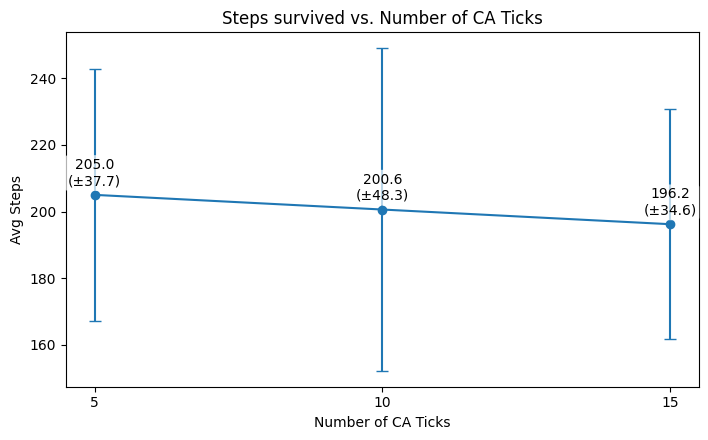

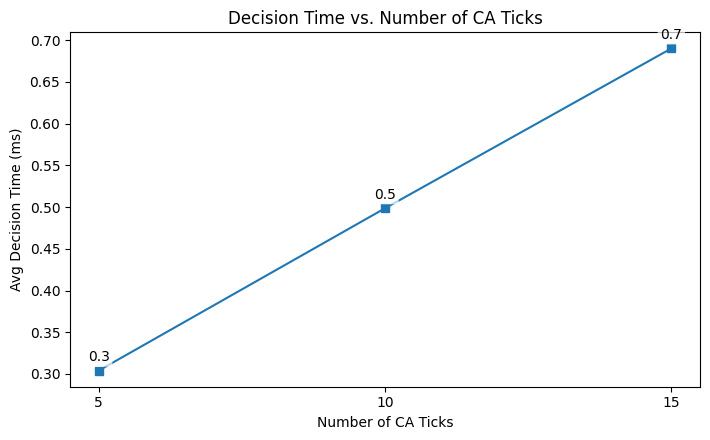

In [69]:
from matplotlib import pyplot as plt

# --- Plot 1: Steps Survived vs. CA Ticks ---
plt.figure(figsize=(7.2, 4.5))
plt.errorbar(
    summary['num_ca_ticks'],
    summary['mean_steps'],
    yerr=summary['std_steps'],
    fmt='-o', capsize=4
)
plt.xlabel('Number of CA Ticks')
plt.ylabel('Avg Steps')
plt.title('Steps survived vs. Number of CA Ticks')
plt.xticks(summary['num_ca_ticks'])

for x, avg, std in zip(summary['num_ca_ticks'], summary['mean_steps'], summary['std_steps']):
    label = f"{avg:.1f}\n(±{std:.1f})"
    plt.annotate(
        label,
        (x, avg),
        textcoords="offset points",
        xytext=(0,7),
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

plt.tight_layout()
plt.show()

# --- Plot 2: Decision Time vs. CA Ticks ---
plt.figure(figsize=(7.2, 4.5))
plt.plot(
    summary['num_ca_ticks'],
    summary['mean_time'],
    '-s',
    label='Avg Time (ms)'
)
plt.xlabel('Number of CA Ticks')
plt.ylabel('Avg Decision Time (ms)')
plt.title('Decision Time vs. Number of CA Ticks')
plt.xticks(summary['num_ca_ticks'])

for x, avg in zip(summary['num_ca_ticks'], summary['mean_time']):
    label = f"{avg:.1f}"
    plt.annotate(
        label,
        (x, avg),
        textcoords="offset points",
        xytext=(0,7),
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

plt.tight_layout()
plt.show()


In [70]:
"""
A quick read of that curve tells the same “sweet-spot” story we saw before—but with a slight twist:

Performance (blue, left axis):

At 5 ticks, you actually got the highest average survival (≈205 steps), but with very large variance.

At 10 ticks, the mean dips slightly (≈200) and the variance tightens up.

At 15 ticks, performance slides a bit more (≈195) and remains fairly consistent.

Compute Cost (orange, right axis):

Grows linearly with ticks: roughly 0.33 ms → 0.50 ms → 0.70 ms.

What it means
Emergence is fast. Even just 5 CA ticks are enough for your rule to self-organize into a workable balancing pattern—longer evolution doesn’t improve the average pole-up time.

Stability vs. variance. Fewer ticks give you high peak performance but wildly varying results (big error bars). Ten ticks trades a tiny loss in mean survival for much more consistent control.

Diminishing (or even negative) returns. Going from 10→15 ticks only hurts average performance, while still increasing latency.

Take-away
If you’re chasing absolute top-end steps, 5 ticks might win occasionally—but it’s unreliable.

If you want repeatable, stable balancing, 10 ticks is the sweet spot: nearly as long on average, much tighter variance, at half the cost of 15 ticks.

Never run more than ~10 ticks—beyond that you pay in compute time for no survival gain (and even a slight loss).

This illustrates the classic complex-systems balancing act: you need enough local updates to let structure emerge, but not so many that the system either over-propagates noise or simply wastes time.
"""

'\nA quick read of that curve tells the same “sweet-spot” story we saw before—but with a slight twist:\n\nPerformance (blue, left axis):\n\nAt 5 ticks, you actually got the highest average survival (≈205 steps), but with very large variance.\n\nAt 10 ticks, the mean dips slightly (≈200) and the variance tightens up.\n\nAt 15 ticks, performance slides a bit more (≈195) and remains fairly consistent.\n\nCompute Cost (orange, right axis):\n\nGrows linearly with ticks: roughly 0.33 ms → 0.50 ms → 0.70 ms.\n\nWhat it means\nEmergence is fast. Even just 5 CA ticks are enough for your rule to self-organize into a workable balancing pattern—longer evolution doesn’t improve the average pole-up time.\n\nStability vs. variance. Fewer ticks give you high peak performance but wildly varying results (big error bars). Ten ticks trades a tiny loss in mean survival for much more consistent control.\n\nDiminishing (or even negative) returns. Going from 10→15 ticks only hurts average performance, while s

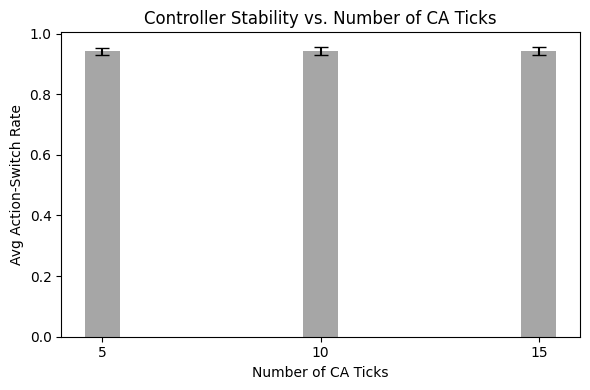

In [71]:
# 5) Plot 2: Controller Stability vs. CA Ticks
plt.figure(figsize=(6,4))
plt.bar(
    summary['num_ca_ticks'], summary['mean_switch'],
    yerr=summary['std_switch'], capsize=5, color='gray', alpha=0.7
)
plt.xlabel('Number of CA Ticks')
plt.ylabel('Avg Action-Switch Rate')
plt.xticks(summary['num_ca_ticks'])
plt.title('Controller Stability vs. Number of CA Ticks')
plt.tight_layout()
plt.show()